## SIFT + Bag of Visual Words

Sacado de https://github.com/gurkandemir/Bag-of-Visual-Words/blob/master/Code%20Files/BoW.py

In [2]:
import argparse
import cv2
import numpy as np 
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score ,ConfusionMatrixDisplay

import joblib

In [3]:
from funciones import make_dataset, split_train_test, get_classes

In [4]:
dir_imagenes_5="images_5/"
dir_labels_5="annotations_5/trimaps_5/"
dir_imagenes="images/"
dir_labels="annotations/trimaps/"
dir_images_small="images_small/"

In [52]:
def getDescriptors(sift, img, plot=False):
    kp, des = sift.detectAndCompute(img, None)
    if plot:
        img=cv2.drawKeypoints(img,kp,img)

        plt.imshow(img)
        plt.show()

    return des

def readImage(img_path, direccion_lbl):
    img = cv2.imread(img_path, 0)
    nombre_archivo_mascara = os.path.splitext(img_path)[0] + '.png'
    nombre_archivo_mascara = os.path.basename(nombre_archivo_mascara)
    ruta_mascara = os.path.join(direccion_lbl, nombre_archivo_mascara)
    mascara = cv2.imread(ruta_mascara, cv2.IMREAD_GRAYSCALE)
    mascara_binaria_1 = cv2.compare(mascara, 1, cv2.CMP_EQ) 
    mascara_binaria_3 = cv2.compare(mascara, 3, cv2.CMP_EQ)

    mascara_binaria = cv2.bitwise_or(mascara_binaria_1, mascara_binaria_3)
    
    imagen_sin_fondo = cv2.bitwise_and(img, img, mask=mascara_binaria)
    return cv2.resize(imagen_sin_fondo,(250,250))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    joblib.dump(kmeans, 'kmeans.sav')
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    joblib.dump(svm, 'svm.sav')

    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(classes))
    cmd.plot()



def plotConfusions(true, predictions ):
    np.set_printoptions(precision=2)

    plotConfusionMatrix(true, predictions, classes=list(set(predictions)),
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=list(set(predictions)), normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print(true)
    print(predictions)
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

def trainModel(images,labels, no_clusters, kernel):
    sift = cv2.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    image_count = len(images)

    for img_path, class_index in zip(images, labels):
 

        train_labels = np.append(train_labels, class_index)
        #try:
        img = readImage(img_path, dir_labels)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)
        #except:
        #    print(img_path)
    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    joblib.dump(im_features, 'im_features.sav')

    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)    
    joblib.dump(scale, 'scale.sav')
    
    im_features = scale.transform(im_features)
    
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

def testModel(test_images, test_labels,kmeans, scale, svm, im_features, no_clusters, kernel, class_names, inferencia=False):

    count = 0
    true = []
    descriptor_list = []
    name_dict = {str(i): class_names[i] for i in range(len(class_names))}
    print(name_dict)

    sift = cv2.SIFT_create()

    for img_path, label in zip(test_images, test_labels):
        img = readImage(img_path, dir_labels)
        des = getDescriptors(sift, img, plot=inferencia)

        if(des is not None):
            count += 1
            descriptor_list.append(des)
            true.append(label)

    #descriptors = vstackDescriptors(descriptor_list)


    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    #predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    #predictions = [k for k, v in name_dict.items() if v in svm.predict(kernel_test)]
    predictions = []
    predictions_name=[]
    for value in svm.predict(kernel_test):
        predictions_name.append(value)
        for k, v in name_dict.items():
            if v == value:
                predictions.append(k)
                break
    print("Test images classified.")
    if inferencia:
        print(predictions_name)
    else:
        
        plotConfusions(true, predictions_name)
        print("Confusion matrixes plotted.")

        findAccuracy(true, predictions_name)
        print("Accuracy calculated.")
        print("Execution done.")

def execute(images_train, images_test, classes_train, classes_test, no_clusters, kernel, classes):
    
    kmeans, scale, svm, im_features = trainModel(images_train,classes_train, no_clusters, kernel)
    testModel(images_test, classes_test, kmeans, scale, svm, im_features, no_clusters, kernel, classes)
def test(images_test, classes_test, no_clusters, kernel, classes):
    im_features=joblib.load('im_features.sav')
    kmeans=joblib.load('kmeans.sav')
    svm=joblib.load('svm.sav')
    scale=joblib.load('scale.sav')
    testModel(images_test, classes_test, kmeans, scale, svm, im_features, no_clusters, kernel, classes)


In [54]:
nombre_csv="datos_gatos.csv"
#make_dataset(dir_imagenes, nombre_csv)

df = pd.read_csv(nombre_csv)
df=df[df['Family'] == 'Gato']
images_train, images_test, classes_train, classes_test=split_train_test(df, 0.9)
classes=get_classes(df)
no_clusters=100
kernel="precomputed"
labels="/home/sere/Escritorio/trabajotimag/annotations/trimaps"
execute(images_train, images_test, classes_train, classes_test, no_clusters, kernel, classes)
#test(images_test, classes_test, no_clusters, kernel, classes)

Siamese_157.png
Abyssinian_62.png
Siamese_84.png
British_Shorthair_109.png
Abyssinian_146.png
Bombay_106.png
Bombay_139.png
Birman_196.png
Abyssinian_33.png
Ragdoll_30.png
Ragdoll_1.png
Sphynx_122.png
Bengal_174.png
Abyssinian_40.png
British_Shorthair_60.png
Egyptian_Mau_54.png
Sphynx_48.png
Ragdoll_27.png
Russian_Blue_152.png
Bombay_41.png
British_Shorthair_26.png
Sphynx_4.png
Persian_74.png
Ragdoll_124.png
Russian_Blue_110.png
Ragdoll_96.png
Birman_54.png
Persian_262.png
Birman_76.png
Sphynx_251.png
Persian_5.png
Maine_Coon_219.png
Maine_Coon_25.png
Persian_141.png
Ragdoll_145.png
Maine_Coon_82.png
Birman_87.png
Persian_264.png
Persian_261.png
Birman_24.png
Ragdoll_83.png
Russian_Blue_144.png
Russian_Blue_155.png
Ragdoll_136.png
Sphynx_238.png
Siamese_164.png
Russian_Blue_211.png
Birman_144.png
Russian_Blue_127.png
Persian_2.png
Abyssinian_116.png
Bengal_155.png
British_Shorthair_203.png
Persian_183.png
Egyptian_Mau_97.png
Russian_Blue_120.png
Siamese_9.png
Abyssinian_81.png
British_

In [45]:
def inferencia_eval(path_image, test_label,no_clusters, kernel, classes):
    kmeans=joblib.load('kmeans.sav')
    scale=joblib.load('scale.sav')
    im_features=joblib.load('im_features.sav')
    svm=joblib.load('svm.sav')
    testModel([path_image], [test_label], kmeans, scale, svm, im_features, no_clusters, kernel, classes, inferencia=True)

{'0': 'Bombay', '1': 'Abyssinian', '2': 'Russian_Blue', '3': 'Bengal', '4': 'Persian', '5': 'Maine_Coon', '6': 'Siamese', '7': 'British_Shorthair', '8': 'Ragdoll', '9': 'Sphynx', '10': 'Birman', '11': 'Egyptian_Mau'}


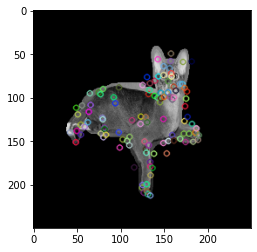

Test images classified.
['Maine_Coon']


In [46]:
inferencia_eval("/home/sere/Escritorio/trabajotimag/images/Abyssinian_1.jpg", "/home/sere/Escritorio/trabajotimag/annotations/trimaps", no_clusters, kernel, classes)